### Analysis with the trained network

This analysis uses the pretrained network

In [10]:
import skimage
skimage.__version__
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import cPickle as pickle
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb


with open('net_PAPER_aug_epoch512_72x72large_net.pickle', 'rb') as f:
    net_pretrain = pickle.load(f)

/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


## The training history

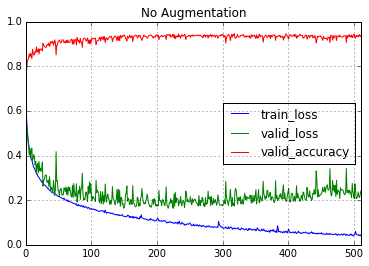

In [12]:
import pandas as pd
dfAug = pd.DataFrame(net_pretrain.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))
dfAug.to_csv("complex_network_no_aug.txt")

In [37]:
np.sum(dfAug['dur']) / (60*60) #Total Training Time

19.17785088347064

The average validation accurracy over the last 100 runs was:

In [43]:
np.mean(dfAug['valid_accuracy'][451:])

0.9313015824095161

## Evaluation on the test set
### Loading and preprocessing the data

In [23]:
start = time.time()
npzfile = np.load('HCS_72x72.npz')
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 10.0489351749


In [24]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [25]:
np.min(X), np.max(X), np.mean(X) #(-2.5272908, 58.301613, -3.3162789e-07)

(-2.5272908, 58.301613, -3.3162789e-07)

In [27]:
Y = np.asarray(Y,dtype='int32')

In [32]:
np.random.seed(seed=42)
perm1 = np.random.permutation(len(Y))
print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
#np.save('premutations.np', perm1)
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]


X_train = X[idx_train,:,:,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:,:,:]
Y_test = Y[idx_test]

Sum of permutation 1401824775


### Prediction on the test set

In [31]:
start = time.time()
pred = net_pretrain.predict(X_test)
print ("The prediction of on {} cells took {}".format(len(X_test), str(time.time() - start)))

The prediction of on 10590 cells took 6.92520523071


In [35]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
print("Total Time {}".format(1.0*np.sum(m[np.diag_indices(4)]) / np.sum(m)))
df

Total Time 0.934372049103


,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7775,13,208,0
PACLITAXEL Pred,28,382,23,1
METOCLOPRAMIDE Pred,414,8,1657,0
DIGOXIN Pred,0,0,0,81


In [36]:
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:])[0])
print('Normalized confusion matrix')
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
#m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(cm_normalized)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

Normalized confusion matrix


,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,0.946209,0.032258,0.110169,0.000000
PACLITAXEL Pred,0.003408,0.947891,0.012182,0.012195
METOCLOPRAMIDE Pred,0.050383,0.019851,0.877648,0.000000
DIGOXIN Pred,0.000000,0.000000,0.000000,0.987805


## Analysis of the wrongly predicted cells

In [46]:
pred_prob = net_pretrain.predict_proba(X_test)

In [54]:
pred_prob = pred_prob[:0:3]